In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import floor
def validFiles(files):
    validFiles = []
    for file in files:
        if os.path.exists(file):
            validFiles.append(file)
    return validFiles


# Read all Files

In [2]:
def getISScheme(studyTitle):
    return studyTitle.split('_')[0]

def getCTScheme(studyTitle):
    # remove everything before the first _ but keep the rest including "_"
    split = studyTitle.split('_')
    return '_'.join(split[1:])

# basic definitions
idleSlopeSchemes = ['Static', 'CMI', 'SI', 'NC']
crossTrafficSchemes = ['NoCT', 'NoCT_NoPCTRes', 'BECT', 'BECT_NoPCTRes', 'PCT']
studyTitles = []
for idleSlopeScheme in idleSlopeSchemes:
    for crossTrafficScheme in crossTrafficSchemes:
        if ((idleSlopeScheme == 'Static' and crossTrafficScheme == 'NoCT_NoPCTRes') 
            or (idleSlopeScheme == 'Static' and crossTrafficScheme == 'BECT_NoPCTRes')
            or (idleSlopeScheme == 'NC' and crossTrafficScheme == 'NoCT_NoPCTRes') 
            or (idleSlopeScheme == 'NC' and crossTrafficScheme == 'BECT_NoPCTRes')):
            continue
        studyTitles.append(idleSlopeScheme + '_' + crossTrafficScheme)
studyTitles

['Static_NoCT',
 'Static_BECT',
 'Static_PCT',
 'CMI_NoCT',
 'CMI_NoCT_NoPCTRes',
 'CMI_BECT',
 'CMI_BECT_NoPCTRes',
 'CMI_PCT',
 'SI_NoCT',
 'SI_NoCT_NoPCTRes',
 'SI_BECT',
 'SI_BECT_NoPCTRes',
 'SI_PCT',
 'NC_NoCT',
 'NC_BECT',
 'NC_PCT']

## Read Simulation Results (Subdir sim/)
Open the Study as an anf-File and select the relevant data in OMNeT++ IDE.
Right click and select "Export Data" -> "JSON" -> Select Use NumPy arrays, and other settings specified below.

Studies are formed for all IdleSlope schemes:
- Static
- CMI 
- Stream Interval (SI)
- Network Calculus (NC) -- from DYRECTsn Framework

For all schemes the following permutations are executed:
- NoCT
- NoCT_NoPCTRes (not for static scheme, as it is not applicable)
- BECT
- BECT_NoPCTRes (not for static scheme, as it is not applicable)
- PCT

The %STUDY% is formed by the scheme and the permutation, e.g. `Static_NoCT` or `SI_BECT_NoPCTRes`.

Table for the settings, all results are Vectors
| Module Filter | Result Name | Target File | Start Time | End Time |
|---------------|-------------|-------------|------------|----------|
| `**.aggregateSwitch.etherMAC[0].**.transmissionSelectionAlgorithm[7]` | reservedBandwidth | `sim/%STUDY%_AggregateIdleSlopes.json` | 0s | 0.2s |
| `**.stageSwitch[*].etherMAC[1].**.transmissionSelectionAlgorithm[7]` | reservedBandwidth | `sim/%STUDY%_StageIdleSlopes.json` | 0s | 0.2s |
| `**.aggregateSwitch.etherMAC[0].**.queue[7]` | delay | `sim/%STUDY%_AggregateDelay.json` | 0.1s | 0.3s |
| `**.aggregateSwitch.etherMAC[0].**.queue[7]` | length | `sim/%STUDY%_AggregateQueue.json` | 0.1s | 0.3s |


In [3]:
def buildSimFileName(studyTitle, valueName):
    return 'sim/' + studyTitle + "_" + valueName + '.json'

def getValueNameFromSimFileName(simFileName):
    split = simFileName.split('/')[-1].split('.')[0].split('_')
    return split[-1]

def getStudyTitleFromSimFileName(simFileName):
    split = simFileName.split('/')[-1].split('.')[0].split('_')
    return '_'.join(split[:-1])


In [4]:
simAggregateSlopeFiles = []
simStageSlopeFiles = []
simQueueFiles = []
simDelayFiles = []
for studyTitle in studyTitles:
    simAggregateSlopeFiles.append(buildSimFileName(studyTitle, 'AggregateIdleSlopes'))
    simStageSlopeFiles.append(buildSimFileName(studyTitle, 'StageIdleSlopes'))
    simQueueFiles.append(buildSimFileName(studyTitle, 'AggregateQueue'))
    simDelayFiles.append(buildSimFileName(studyTitle, 'AggregateDelay'))

# check if the files exist and remove the ones that do not from the list
simAggregateSlopeFiles = validFiles(simAggregateSlopeFiles)
simStageSlopeFiles = validFiles(simStageSlopeFiles)
simQueueFiles = validFiles(simQueueFiles)
simDelayFiles = validFiles(simDelayFiles)

print ("valid sim files found:")
print (simAggregateSlopeFiles)
print (simStageSlopeFiles)
print (simQueueFiles)
print (simDelayFiles)

valid sim files found:
['sim/Static_NoCT_AggregateIdleSlopes.json', 'sim/Static_BECT_AggregateIdleSlopes.json', 'sim/Static_PCT_AggregateIdleSlopes.json', 'sim/CMI_NoCT_AggregateIdleSlopes.json', 'sim/CMI_NoCT_NoPCTRes_AggregateIdleSlopes.json', 'sim/CMI_BECT_AggregateIdleSlopes.json', 'sim/CMI_BECT_NoPCTRes_AggregateIdleSlopes.json', 'sim/CMI_PCT_AggregateIdleSlopes.json', 'sim/SI_NoCT_AggregateIdleSlopes.json', 'sim/SI_NoCT_NoPCTRes_AggregateIdleSlopes.json', 'sim/SI_BECT_AggregateIdleSlopes.json', 'sim/SI_BECT_NoPCTRes_AggregateIdleSlopes.json', 'sim/SI_PCT_AggregateIdleSlopes.json']
['sim/Static_NoCT_StageIdleSlopes.json', 'sim/Static_BECT_StageIdleSlopes.json', 'sim/Static_PCT_StageIdleSlopes.json', 'sim/CMI_NoCT_StageIdleSlopes.json', 'sim/CMI_NoCT_NoPCTRes_StageIdleSlopes.json', 'sim/CMI_BECT_StageIdleSlopes.json', 'sim/CMI_BECT_NoPCTRes_StageIdleSlopes.json', 'sim/CMI_PCT_StageIdleSlopes.json', 'sim/SI_NoCT_StageIdleSlopes.json', 'sim/SI_NoCT_NoPCTRes_StageIdleSlopes.json', 'si

### Reserverd Bandwidth for Aggregate and Stage Switches

In [5]:
def getMaxIdleSlopesForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxIdleSlope = 0
        for vector in sim[study]["vectors"]:
            if "reservedBandwidth" in vector["name"]:
                maxIdleSlope = np.max([np.max(vector["value"]),maxIdleSlope])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxIdleSlope
    return results

def getMaxSlopesForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxIdleSlopesForSimStudy(simFile, returnFirst)
    return results

In [6]:
simAggregateIdleSlopes = getMaxSlopesForStudyFiles(simAggregateSlopeFiles, returnFirst=True)
print(simAggregateIdleSlopes)

{'Static': {'NoCT': {(11, 19): 75000000, (11, 17): 75000000, (11, 18): 75000000, (11, 16): 75000000, (11, 14): 75000000, (11, 15): 75000000, (10, 5): 75000000, (10, 6): 75000000, (10, 9): 75000000, (11, 11): 75000000, (11, 12): 75000000, (10, 18): 75000000, (10, 4): 75000000, (10, 3): 75000000, (10, 17): 75000000, (10, 11): 75000000, (10, 12): 75000000, (10, 13): 75000000, (10, 14): 75000000, (10, 15): 75000000, (10, 16): 75000000, (10, 19): 75000000, (10, 2): 75000000, (10, 7): 75000000, (10, 1): 75000000, (10, 8): 75000000, (11, 1): 75000000, (11, 10): 75000000, (10, 20): 75000000, (10, 10): 75000000, (11, 13): 75000000, (12, 12): 75000000, (12, 7): 75000000, (13, 14): 75000000, (13, 4): 75000000, (13, 6): 75000000, (13, 9): 75000000, (12, 11): 75000000, (2, 12): 75000000, (11, 20): 75000000, (2, 18): 75000000, (2, 20): 75000000, (11, 5): 75000000, (2, 3): 75000000, (2, 4): 75000000, (12, 2): 75000000, (13, 11): 75000000, (13, 15): 75000000, (13, 5): 75000000, (12, 19): 75000000, (2,

In [7]:
simStageIdleSlopes = getMaxSlopesForStudyFiles(simStageSlopeFiles, returnFirst=False)
print(simStageIdleSlopes)

{'Static': {'NoCT': {(11, 18): 75000000, (12, 12): 75000000, (12, 9): 75000000, (12, 18): 75000000, (12, 13): 75000000, (12, 17): 75000000, (13, 1): 75000000, (13, 10): 75000000, (12, 14): 75000000, (12, 15): 75000000, (12, 3): 75000000, (11, 9): 75000000, (11, 8): 75000000, (12, 2): 75000000, (11, 5): 75000000, (11, 17): 75000000, (11, 19): 75000000, (12, 10): 75000000, (12, 5): 75000000, (12, 11): 75000000, (11, 6): 75000000, (11, 7): 75000000, (11, 15): 75000000, (12, 19): 75000000, (11, 2): 75000000, (13, 11): 75000000, (13, 12): 75000000, (12, 1): 75000000, (12, 4): 75000000, (11, 20): 75000000, (11, 3): 75000000, (11, 16): 75000000, (11, 4): 75000000, (12, 6): 75000000, (13, 14): 75000000, (12, 7): 75000000, (12, 8): 75000000, (12, 20): 75000000, (13, 15): 75000000, (13, 13): 75000000, (12, 16): 75000000, (13, 16): 75000000, (11, 1): 75000000, (11, 12): 75000000, (11, 11): 75000000, (10, 20): 75000000, (11, 13): 75000000, (10, 16): 75000000, (10, 18): 75000000, (10, 15): 75000000

### Aggregate Switch Max Queue Length

In [8]:
def getMaxQueueForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxQueue = 0
        for vector in sim[study]["vectors"]:
            if "length" in vector["name"]:
                maxQueue = np.max([np.max(vector["value"]),maxQueue])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxQueue
    return results

def getMaxQueueForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxQueueForSimStudy(simFile, returnFirst)
    return results

In [9]:
simAggregateQueues = getMaxQueueForStudyFiles(simQueueFiles, returnFirst=True)
print(simAggregateQueues)

{'Static': {'NoCT': {(10, 5): 9, (10, 6): 9, (10, 7): 9, (11, 14): 10, (11, 16): 10, (11, 12): 10, (11, 5): 10, (10, 17): 9, (10, 16): 9, (10, 20): 9, (10, 8): 9, (11, 4): 10, (11, 13): 10, (10, 18): 9, (11, 19): 10, (11, 17): 10, (10, 12): 9, (11, 7): 10, (11, 11): 10, (11, 8): 10, (11, 9): 10, (12, 1): 11, (10, 13): 9, (11, 10): 10, (11, 15): 10, (10, 10): 9, (10, 1): 9, (10, 11): 9, (10, 14): 9, (10, 15): 9, (10, 9): 9, (11, 1): 11, (11, 2): 10, (11, 3): 10, (11, 20): 10, (10, 4): 9, (11, 18): 10, (11, 6): 10, (10, 19): 9, (10, 2): 9, (10, 3): 9, (12, 10): 11, (12, 11): 11, (12, 15): 11, (12, 3): 12, (12, 4): 11, (12, 6): 11, (12, 13): 11, (12, 12): 11, (12, 7): 11, (12, 5): 11, (12, 17): 11, (12, 16): 11, (12, 8): 11, (12, 14): 11, (12, 20): 11, (12, 18): 11, (12, 19): 11, (12, 2): 11, (3, 10): 2, (3, 19): 2, (3, 9): 2, (4, 18): 3, (5, 1): 4, (3, 13): 2, (3, 18): 2, (3, 20): 2, (4, 1): 3, (3, 6): 2, (4, 13): 3, (3, 16): 2, (4, 16): 3, (4, 20): 3, (4, 4): 3, (4, 7): 3, (4, 10): 3, (

### Aggregate Switch Max Queue Delay

In [10]:
def getMaxDelayForSimStudy(simFile, returnFirst=True):
    sim = pd.read_json(simFile)
    results = dict()
    for study in sim:
        stages = int(sim[study]["itervars"]["S"])
        inputLinks = int(sim[study]["itervars"]["IL"])
        maxDelay = 0
        for vector in sim[study]["vectors"]:
            if "delay" in vector["name"]:
                maxDelay = np.max([np.max(vector["value"]),maxDelay])
                if returnFirst:
                    break
        results[(inputLinks,stages)] = maxDelay
    return results

def getMaxDelayForStudyFiles(simFiles, returnFirst=True):
    results = dict()
    for simFile in simFiles:
        study = getStudyTitleFromSimFileName(simFile)
        isScheme = getISScheme(study)
        ctScheme = getCTScheme(study)
        if isScheme not in results:
            results[isScheme] = dict()
        results[isScheme][ctScheme] = getMaxDelayForSimStudy(simFile, returnFirst)
    return results

In [11]:
simAggregateDelays = getMaxDelayForStudyFiles(simDelayFiles, returnFirst=False)
print(simAggregateDelays)

{'Static': {'NoCT': {(10, 5): 0.000112146072, (10, 6): 0.00010782000000000001, (10, 7): 0.00010782000000000001, (11, 14): 0.00010812, (11, 16): 0.00010812, (11, 12): 0.00010812, (11, 5): 0.00010812, (10, 17): 0.00010782000000000001, (10, 16): 0.00010782000000000001, (10, 20): 0.00010782000000000001, (10, 8): 0.00010782000000000001, (11, 4): 0.00010812, (11, 13): 0.00010812, (10, 18): 0.00010782000000000001, (11, 19): 0.00010812, (11, 17): 0.00010812, (10, 12): 0.00010782000000000001, (11, 7): 0.000108168251, (11, 11): 0.00010812, (11, 8): 0.0001126, (11, 9): 0.00010812, (12, 1): 0.00010834, (10, 13): 0.00011142, (11, 10): 0.00010862, (11, 15): 0.00010816000000000001, (10, 10): 0.00010782000000000001, (10, 1): 0.00010782000000000001, (10, 11): 0.00010782000000000001, (10, 14): 0.00010782000000000001, (10, 15): 0.00010782000000000001, (10, 9): 0.00010782000000000001, (11, 1): 0.00010813, (11, 2): 0.00010812500000000001, (11, 3): 0.00010812, (11, 20): 0.00010812, (10, 4): 0.00010782000000

### Export Reserver Bandwidth for Aggregate and Stage Switches to be used in Q-Formula

In [12]:
# print a python dictionary as a lookup table for the idle slopes of the aggregate switch
print("simIdleSlopesAggregate = {")
for isSchema in simAggregateIdleSlopes:
    for ctScheme in simAggregateIdleSlopes[isSchema]:
        print("    '" + isSchema + "_" + ctScheme + "': {")
        for key in simAggregateIdleSlopes[isSchema][ctScheme]:
            print("        " + str(key) + ": " + str(simAggregateIdleSlopes[isSchema][ctScheme][key]) + ",")
        print("    },")
print("}")

simIdleSlopesAggregate = {
    'Static_NoCT': {
        (11, 19): 75000000,
        (11, 17): 75000000,
        (11, 18): 75000000,
        (11, 16): 75000000,
        (11, 14): 75000000,
        (11, 15): 75000000,
        (10, 5): 75000000,
        (10, 6): 75000000,
        (10, 9): 75000000,
        (11, 11): 75000000,
        (11, 12): 75000000,
        (10, 18): 75000000,
        (10, 4): 75000000,
        (10, 3): 75000000,
        (10, 17): 75000000,
        (10, 11): 75000000,
        (10, 12): 75000000,
        (10, 13): 75000000,
        (10, 14): 75000000,
        (10, 15): 75000000,
        (10, 16): 75000000,
        (10, 19): 75000000,
        (10, 2): 75000000,
        (10, 7): 75000000,
        (10, 1): 75000000,
        (10, 8): 75000000,
        (11, 1): 75000000,
        (11, 10): 75000000,
        (10, 20): 75000000,
        (10, 10): 75000000,
        (11, 13): 75000000,
        (12, 12): 75000000,
        (12, 7): 75000000,
        (13, 14): 75000000,
        (13

In [13]:
# print a python dictionary as a lookup table for the idle slopes of the aggregate switch
print("simIdleSlopesStages = {")
for isSchema in simStageIdleSlopes:
    for ctScheme in simStageIdleSlopes[isSchema]:
        print("    '" + isSchema + "_" + ctScheme + "': {")
        for key in simStageIdleSlopes[isSchema][ctScheme]:
            print("        " + str(key) + ": " + str(simStageIdleSlopes[isSchema][ctScheme][key]) + ",")
        print("    },")
print("}")

simIdleSlopesStages = {
    'Static_NoCT': {
        (11, 18): 75000000,
        (12, 12): 75000000,
        (12, 9): 75000000,
        (12, 18): 75000000,
        (12, 13): 75000000,
        (12, 17): 75000000,
        (13, 1): 75000000,
        (13, 10): 75000000,
        (12, 14): 75000000,
        (12, 15): 75000000,
        (12, 3): 75000000,
        (11, 9): 75000000,
        (11, 8): 75000000,
        (12, 2): 75000000,
        (11, 5): 75000000,
        (11, 17): 75000000,
        (11, 19): 75000000,
        (12, 10): 75000000,
        (12, 5): 75000000,
        (12, 11): 75000000,
        (11, 6): 75000000,
        (11, 7): 75000000,
        (11, 15): 75000000,
        (12, 19): 75000000,
        (11, 2): 75000000,
        (13, 11): 75000000,
        (13, 12): 75000000,
        (12, 1): 75000000,
        (12, 4): 75000000,
        (11, 20): 75000000,
        (11, 3): 75000000,
        (11, 16): 75000000,
        (11, 4): 75000000,
        (12, 6): 75000000,
        (13, 14): 7

## Read Q-Formula Analysis Results

## Read DNC Results

In [14]:
dncFiles = {
    "Static": "dnc/mds_20240709_215616_static.csv",
    "CMI_NoPCTRes": "dnc/mds_20240709_215616_cmi_nopctres.csv", # not done yet
    "CMI": "dnc/mds_20240709_215616_cmi.csv",# not done yet
    "SI_NoPCTRes": "dnc/mds_20240709_215616_si_nopctres.csv",# not done yet
    "SI": "dnc/mds_20240709_215616_si.csv",# not done yet
    "NC_NoPCTRes": "dnc/mds_20240709_215616_nc_nopctres.csv",# not done yet
    "NC": "dnc/mds_20240709_215616_nc.csv",# not done yet
}

In [15]:
validFiles = dict()
for key in dncFiles:
    if os.path.exists(dncFiles[key]):
        validFiles[key] = dncFiles[key]
dncFiles = validFiles
print(dncFiles)

{'Static': 'dnc/mds_20240709_215616_static.csv'}


In [16]:
dncAggregateIdleSlopes = dict()
dncStageIdleSlopes = dict()
dncAggregateDelays = dict()
for key in dncFiles:
    print (key)
    dnc = pd.read_csv(dncFiles[key])
    for index, row in dnc.iterrows():
        stages = row['numStages']
        inputLinks = row['numInputLinks']
        aggregateSlope = row['aggregateIdleSlope']
        stageSlopes = row['stageIdleSlope']
        delay = row['maxDelay']
        if key not in dncAggregateIdleSlopes:
            dncAggregateIdleSlopes[key] = dict()
            dncStageIdleSlopes[key] = dict()
            dncAggregateDelays[key] = dict()
        dncAggregateIdleSlopes[key][(inputLinks,stages)] = aggregateSlope
        dncStageIdleSlopes[key][(inputLinks,stages)] = stageSlopes
        dncAggregateDelays[key][(inputLinks,stages)] = delay
print(dncAggregateIdleSlopes)
print(dncStageIdleSlopes)
print(dncAggregateDelays)


Static
{'Static': {(2, 1): 75000000.0, (3, 1): 75000000.0, (4, 1): 75000000.0, (5, 1): 75000000.0, (6, 1): 75000000.0, (7, 1): 75000000.0, (8, 1): 75000000.0, (9, 1): 75000000.0, (10, 1): 75000000.0, (11, 1): 75000000.0, (12, 1): 75000000.0, (13, 1): 75000000.0, (1, 2): 75000000.0, (2, 2): 75000000.0, (3, 2): 75000000.0, (4, 2): 75000000.0, (5, 2): 75000000.0, (6, 2): 75000000.0, (7, 2): 75000000.0, (8, 2): 75000000.0, (9, 2): 75000000.0, (10, 2): 75000000.0, (11, 2): 75000000.0, (12, 2): 75000000.0, (13, 2): 75000000.0, (1, 3): 75000000.0, (2, 3): 75000000.0, (3, 3): 75000000.0, (4, 3): 75000000.0, (5, 3): 75000000.0, (6, 3): 75000000.0, (7, 3): 75000000.0, (8, 3): 75000000.0, (9, 3): 75000000.0, (10, 3): 75000000.0, (11, 3): 75000000.0, (12, 3): 75000000.0, (13, 3): 75000000.0, (1, 4): 75000000.0, (2, 4): 75000000.0, (3, 4): 75000000.0, (4, 4): 75000000.0, (5, 4): 75000000.0, (6, 4): 75000000.0, (7, 4): 75000000.0, (8, 4): 75000000.0, (9, 4): 75000000.0, (10, 4): 75000000.0, (11, 4):

# Plot the Results

## Idle Slope Analysis For input Links and 8 Stages

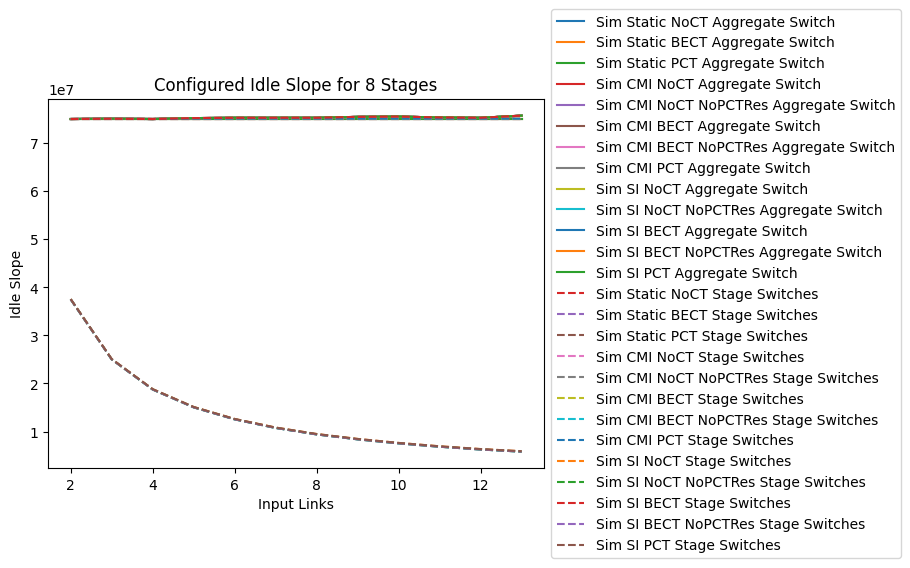

In [17]:
stages = 8
# plot the aggregate idle slopes from simAggregateIdleSlopes
fig, ax = plt.subplots()
for isScheme in simAggregateIdleSlopes:
    for ctScheme in simAggregateIdleSlopes[isScheme]:
        slopes = dict()
        for key in simAggregateIdleSlopes[isScheme][ctScheme]:
            if key[1] == stages:
                slopes[key[0]] = simAggregateIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Aggregate Switch'
        ax.plot(slopes.keys(), slopes.values(), label=name)
# add the stage slopes
for isScheme in simStageIdleSlopes:
    for ctScheme in simStageIdleSlopes[isScheme]:
        slopes = dict()
        for key in simStageIdleSlopes[isScheme][ctScheme]:
            if key[1] == stages:
                slopes[key[0]] = simStageIdleSlopes[isScheme][ctScheme][key]
        slopes = dict(sorted(slopes.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ") + ' Stage Switches'
        ax.plot(slopes.keys(), slopes.values(), label=name, linestyle='dashed')
ax.set_xlabel('Input Links')
ax.set_ylabel('Idle Slope')
ax.set_title('Configured Idle Slope for ' + str(stages) + ' Stages')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


## Delay Analysis for Input Links and 8 Stages

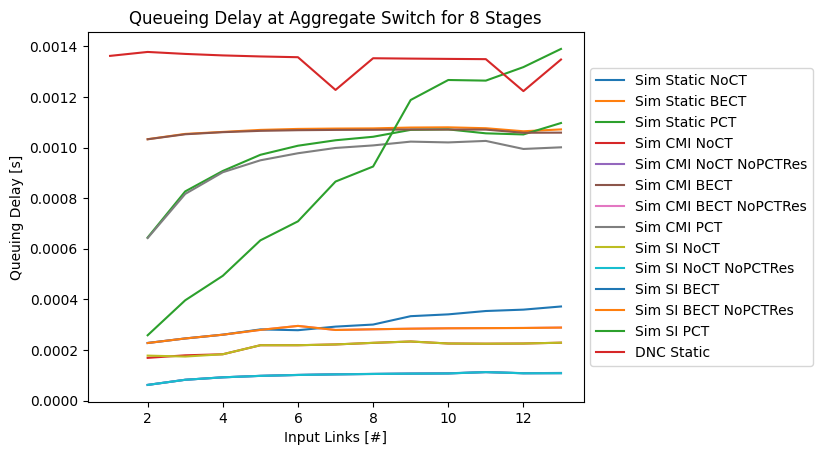

In [18]:
stages = 8
# plot the aggregate delays from simAggregateDelays
fig, ax = plt.subplots()
for isScheme in simAggregateDelays:
    for ctScheme in simAggregateDelays[isScheme]:
        delays = dict()
        for key in simAggregateDelays[isScheme][ctScheme]:
            if key[1] == stages:
                delays[key[0]] = simAggregateDelays[isScheme][ctScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ")
        ax.plot(delays.keys(), delays.values(), label=name)
# plot the aggregate delays from dncAggregateDelays
for study in dncAggregateDelays:
    delays = dict()
    for key in dncAggregateDelays[study]:
        if key[1] == stages:
            delays[key[0]] = dncAggregateDelays[study][key]
    delays = dict(sorted(delays.items()))
    name = "DNC " + study
    ax.plot(delays.keys(), delays.values(), label=name)
ax.set_xlabel('Input Links [#]')
ax.set_ylabel('Queuing Delay [s]')
ax.set_title('Queueing Delay at Aggregate Switch for ' + str(stages) + ' Stages')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Delay Analysis for the Number of Stages and 13 Input Links

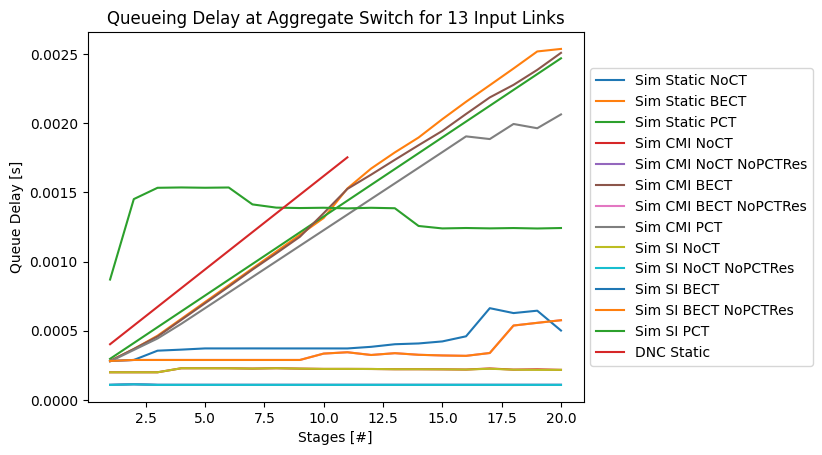

In [19]:
inputLinks = 13
# plot the aggregate delays from simAggregateDelays
fig, ax = plt.subplots()
for isScheme in simAggregateDelays:
    for ctScheme in simAggregateDelays[isScheme]:
        delays = dict()
        for key in simAggregateDelays[isScheme][ctScheme]:
            if key[0] == inputLinks:
                delays[key[1]] = simAggregateDelays[isScheme][ctScheme][key]
        delays = dict(sorted(delays.items()))
        name = "Sim " + isScheme + ' ' + ctScheme.replace("_", " ")
        ax.plot(delays.keys(), delays.values(), label=name)
# plot the aggregate delays from dncAggregateDelays
for study in dncAggregateDelays:
    delays = dict()
    for key in dncAggregateDelays[study]:
        if key[0] == inputLinks:
            delays[key[1]] = dncAggregateDelays[study][key]
    delays = dict(sorted(delays.items()))
    name = "DNC " + study
    ax.plot(delays.keys(), delays.values(), label=name)
ax.set_xlabel('Stages [#]')
ax.set_ylabel('Queue Delay [s]')
ax.set_title('Queueing Delay at Aggregate Switch for ' + str(inputLinks) + ' Input Links')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# Export DNC Configuration for Study

In [49]:
exportFile = "MaxDelayStudyConfigurations.java"
# export a java class with static getter methods for the data from simAggregateIdleSlopes, simIdleSlopesStages
with open(exportFile, 'w') as file:
    file.write("/**\n")
    file.write(" * This file was generated by a script.\n")
    file.write(" * It contains the lookup tables for the idle slopes of the aggregate and stage switches\n")
    file.write(" * from the simulation and the NC tool for calculation in DNC tool.\n")
    file.write(" */\n")
    file.write("package org.networkcalculus.dnc.demos;\n")
    file.write("\n")
    file.write("import org.apache.commons.math3.util.Pair;\n")
    file.write("import java.util.HashMap;\n")
    file.write("import java.util.Map;\n")
    file.write("\n")
    file.write("public class MaxDelayStudyConfigurations {\n")
    # stage idle slopes data structure
    file.write("    public Map<String, Map<Pair<Integer, Integer>, Integer>> simAggregateIdleSlopes;\n")
    file.write("    public Map<String, Map<Pair<Integer, Integer>, Integer>> simStageIdleSlopes;\n")
    file.write("\n")
    file.write("    public MaxDelayStudyConfigurations() {\n")
    file.write("        initializeSimStageIdleSlope();\n")
    file.write("        initializeSimAggregateIdleSlope();\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    private void initializeSimAggregateIdleSlope() {\n")
    file.write("        simAggregateIdleSlopes = new HashMap<>();\n")
    for isScheme in simAggregateIdleSlopes:
        for ctScheme in simAggregateIdleSlopes[isScheme]:
            file.write("        initializeSimAggregateIdleSlope_" + isScheme + "_" + ctScheme + "();\n")
    file.write("    }\n")
    file.write("\n")
    for isScheme in simAggregateIdleSlopes:
        for ctScheme in simAggregateIdleSlopes[isScheme]:
            file.write("    private void initializeSimAggregateIdleSlope_" + isScheme + "_" + ctScheme + "() {\n")
            file.write("        simAggregateIdleSlopes.put(\"" + isScheme + "_" + ctScheme + "\", new HashMap<>());\n")
            for key in simAggregateIdleSlopes[isScheme][ctScheme]:
                file.write("        simAggregateIdleSlopes.get(\"" + isScheme + "_" + ctScheme + "\").put(new Pair<>(" + str(key[0]) + ", " + str(key[1]) + "), " + str(simAggregateIdleSlopes[isScheme][ctScheme][key]) + ");\n")
            file.write("    }\n")
            file.write("\n")  
    file.write("    private void initializeSimStageIdleSlope() {\n")
    file.write("        simStageIdleSlopes = new HashMap<>();\n")
    for isScheme in simStageIdleSlopes:
        for ctScheme in simStageIdleSlopes[isScheme]:
            file.write("        initializeSimStageIdleSlope_" + isScheme + "_" + ctScheme + "();\n")
    file.write("    }\n")
    file.write("\n")
    for isScheme in simStageIdleSlopes:
        for ctScheme in simStageIdleSlopes[isScheme]:
            file.write("    private void initializeSimStageIdleSlope_" + isScheme + "_" + ctScheme + "() {\n")
            file.write("        simStageIdleSlopes.put(\"" + isScheme + "_" + ctScheme + "\", new HashMap<>());\n")
            for key in simStageIdleSlopes[isScheme][ctScheme]:
                file.write("        simStageIdleSlopes.get(\"" + isScheme + "_" + ctScheme + "\").put(new Pair<>(" + str(key[0]) + ", " + str(key[1]) + "), " + str(simStageIdleSlopes[isScheme][ctScheme][key]) + ");\n")
            file.write("    }\n")
            file.write("\n")       
    file.write("    public int getSimStageIdleSlope(String study, int inputLinks, int stages) {\n")
    file.write("        return simStageIdleSlopes.get(study).get(new Pair<>(inputLinks, stages));\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    public int getSimAggregateIdleSlope(String study, int inputLinks, int stages) {\n")
    file.write("        return simAggregateIdleSlopes.get(study).get(new Pair<>(inputLinks, stages));\n")
    file.write("    }\n")
    file.write("\n")
    file.write("    public boolean existsSimScenario(String study, int inputLinks, int stages) {\n")
    file.write("        if (!(simStageIdleSlopes.containsKey(study) && simStageIdleSlopes.get(study).containsKey(new Pair<>(inputLinks, stages)))) {\n")
    file.write("            return false;\n")
    file.write("        }\n")
    file.write("        return simAggregateIdleSlopes.containsKey(study) && simAggregateIdleSlopes.get(study).containsKey(new Pair<>(inputLinks, stages));\n")
    file.write("    }\n")

    # main test method
    file.write("    public static void main(String[] args) {\n")
    file.write("        MaxDelayStudyConfigurations config = new MaxDelayStudyConfigurations();\n")
    file.write("        System.out.println(config.existsSimScenario(\"Static_NoCT\", 13, 8) + \" should be true\");\n")
    file.write("        System.out.println(config.existsSimScenario(\"Should_Not_Exist\", 13, 8) + \" should be false\");\n")
    file.write("        System.out.println(config.getSimStageIdleSlope(\"Static_NoCT\", 13, 8) + \" should be 75000000\");\n")
    file.write("        System.out.println(config.getSimAggregateIdleSlope(\"Static_NoCT\", 13, 8) + \" should be 75000000\");\n")
    file.write("    }\n")
    file.write("}\n")
    file.write("\n")


# Export Results to CSV for Latex Plotting

# Sim Par Generation

In [21]:
totalBandwidth = 75000000
linkrate = 100000000
talkerInterval = 0.000125
ctInterval = 0.1
talkerSize = floor(((totalBandwidth / 8) * talkerInterval)/3)
talkerSizeAsStr = "floor(((" + str(totalBandwidth) + " / 8) * " + str(talkerInterval) + ") / ${IL})"
print("talkerSize " + talkerSizeAsStr)
ctSize = floor(((totalBandwidth / 8) * talkerInterval) - (((totalBandwidth / 8) * talkerInterval) / 3))
ctSizeAsStr = "floor(((" + str(totalBandwidth) + " / 8) * " + str(talkerInterval) + ") - (((" + str(totalBandwidth) + " / 8) * " + str(talkerInterval) + ") / ${IL}))"
print("ctSize " + ctSizeAsStr)
idleslope = (talkerSize*8 / talkerInterval) + (ctSize*8 / ctInterval)
idleslopeAsStr = "((" + talkerSizeAsStr + " * 8 / " + str(talkerInterval) + ") + (" + ctSizeAsStr + " * 8 / " + str(ctInterval) + "))"
print("idleslope " + idleslopeAsStr)
sendslope = (linkrate - idleslope) / linkrate
sendslopeAsStr = "(" + str(linkrate) + " - " + idleslopeAsStr + ") / " + str(linkrate)
print("sendslope " + sendslopeAsStr)
delay = (((ctSize * 8) * sendslope) / idleslope)
delayAsStr = "(((" + ctSizeAsStr + " * 8) * " + sendslopeAsStr + ") / " + idleslopeAsStr + ")"
print("delay " + delayAsStr)
delay

talkerSize floor(((75000000 / 8) * 0.000125) / ${IL})
ctSize floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL}))
idleslope ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1))
sendslope (100000000 - ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1))) / 100000000
delay (((floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8) * (100000000 - ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1))) / 100000000) / ((floor(((75000000 / 8) * 0.000125) / ${IL}) * 8 / 0.000125) + (floor(((75000000 / 8) * 0.000125) - (((75000000 / 8) * 0.000125) / ${IL})) * 8 / 0.1)))


0.0001872154738299321